#**Homework 5 - Transcriptomics**

The purpose of this homework is to teach you how to identify significantly differential mRNA abundances and perform a pathway enrichment analysis using two different bioinformatics tools.

License: This document is open source under [CC BY-ND 4.0](https://en.wikipedia.org/wiki/Creative_Commons_license).

# **Completing the Assignment**

This notebook is your homework #5. To complete the homework and receive credit, you need to work through all 5 sections. Within each thematic section is a mix of explanatory text cells and code cells. Some code cells have code written for you; some ask you to write code. At the end of each section are 'Practice Problems'. You should write code to answer the questions - following the directions given. Once you are ready to submit your answer, run the submission code block below every question block. If you get a question wrong, fix your code and try again. If you get stumped, ask for a hint using the hint code block below each submission code block. This homework also has several sections of code with significant compute, and that might take a few minutes.

Your first step will be to save this notebook as a copy so that you can edit it. (File->Save a copy in Drive).

Have fun.

# **Learning Outcomes**
#### Biological

*   Identify differential expression of transcripts between tumor and normal samples.
*   Interpret a gene list as a functional set of pathways.
*   Justify choice of enrichment methods based on gene list characteristics.

#### Computational

*   Perform pathway enrichment analysis.
*   Create boxplot visualization.
*   Perform unparied *t* test with multiple hypothesis correction.

# **Topics and Background Reading**

In molecular biology, [messenger RNA (mRNA)](https://en.wikipedia.org/wiki/Messenger_RNA) is a transcript of a gene, and is translated by a ribosome in the process of synthesizing a protein. Generally, when people say 'gene expression', they are talking about mRNA abundance.

Today's homework uses [transcriptomics](https://en.wikipedia.org/wiki/Transcriptome) from [RNA-seq data](https://en.wikipedia.org/wiki/RNA-Seq), which measures the abundance of mRNA transcripts. One of the big uses of transcriptomic data is to find differentially abundant mRNA species between multiple conditions. In this notebook/homework we will identify these, and compare our answers between three different cancer types, lung adenocarcinoma, lung squamous cell carcinoma, and head/neck squamous cell carcinoma.

* [Mortazavi 2008](https://pubmed.ncbi.nlm.nih.gov/18516045/)

A [biological pathway](https://en.wikipedia.org/wiki/Biological_pathway) is a series of interactions among molecules in a cell that leads to a certain product or a change in a cell. Some of the most common biological pathways are involved in metabolism, the regulation of gene expression, and signaling. In bioinformatics we can use tools to identify enrichment of specific functional gene sets which can help us identify key genes related to a particular pathological condition such as cancer.

* [Subramanian 2005](https://pubmed.ncbi.nlm.nih.gov/16199517/)
* [Reimand 2019](https://pubmed.ncbi.nlm.nih.gov/30664679/)

# Part 1. Setup

First we need to install and import the cptac and biograder packages along with a few other packages.

In [ ]:
!pip install cptac
!pip install biograder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 8.2 MB/s 
     |████████████████████████████████| 96 kB 5.4 MB/s 
     |████████████████████████████████| 128 kB 41.3 MB/s 
  Created wheel for gtfparse: filename=gtfparse-1.2.1-py3-none-any.whl size=11637 sha256=4f6920c70a8428d588296305fb9ace70c06923aae6d7202ba623a38d2a025f4f
  Stored in directory: /root/.cache/pip/wheels/a9/7a/45/434ba7d04afbfcc5c12195682413f53ecd4580dfd62905a672
Successfully built gtfparse
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import statistics

Lastly, we need to get the homework autograder. This will have the same steps of server install, importing and object creation.

In [ ]:
import biograder
#The mRNA homework is #5
biograder.download("bio462_hw5")
myID = "joeaman" #Your student id, or 'temp'
hw = biograder.bio462_hw5(student_id = myID) #Instantiate the homework grader object.

We will be working with three similar cancer cohorts in this homework. Examples will be shown to you with the lung adenocarcinoma (LUAD) cohort. Afterwards some questions will ask you to perform analyses on the lung squamous cell carcinoma (LSCC) cohort and the head/neck squamous cell carcinoma (HNSCC) cohort for comparision.

In [ ]:
#Be patient, this may take a few minutes depending on your internet connection.
import cptac

cptac.download('luad')
lu = cptac.Luad()
cptac.download('lscc')
ls = cptac.Lscc()
cptac.download('hnscc')
hn = cptac.Hnscc()

The following code will install and import the GSEA/Enrichr and g:Profiler tools for us to use throughout the homework.

In [ ]:
!pip install gseapy
import gseapy as gp
from gseapy.plot import barplot, dotplot

In [ ]:
!pip install gprofiler-official
from gprofiler import GProfiler

# Part 2. Differential Analysis

The transcriptomics dataframe is comprised of mRNA abundance data for different genes. The data values have been transformed from a metric like FPKM, or RSEM and are not easily compared between cohorts.  

The first part of today's homework is to learn how to identify significantly differential mRNA abundances between tumor tissue and normal tissue.

In [ ]:
#This code joins the Sample_Tumor_Normal column of the clinical df with the transcriptomics df.
data = lu.join_metadata_to_omics(metadata_df_name='clinical',omics_df_name='transcriptomics',metadata_cols = ["Sample_Tumor_Normal"])
data

In order to determine if there is a statistically significant difference between an mRNA abundance in tumor tissue vs normal tissue we can perform a t-test. Let's try it with the TP53 mRNA abundance.

In [ ]:
tumor_type = data.loc[data['Sample_Tumor_Normal'] == 'Tumor']
normal_type = data.loc[data['Sample_Tumor_Normal'] == 'Normal']
ttest = stats.ttest_ind(normal_type['TP53_transcriptomics'].dropna(axis=0), tumor_type['TP53_transcriptomics'].dropna(axis=0))
print(ttest.pvalue)

2.7454342269816476e-16


Here we can see that the p-value returned from the t-test is below a typical cutoff value of 0.05. Therefore, we would assert that TP53 mRNA abundance in tumor tissue is significantly different from normal tissue.

We can also make a boxplot to visualize this difference. We are using the Python plotting library seaborn, commonly aliased as 'sns'. In addition to a box plot, we are adding on top of that a stripplot to explicitly show every data point. I find that to be very helpful.

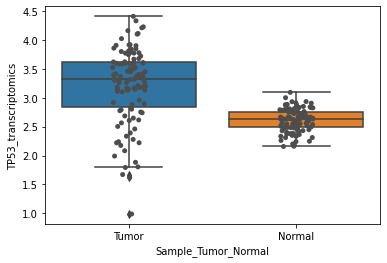

In [ ]:
data_boxplot = sns.boxplot(data=data, x='Sample_Tumor_Normal', y='TP53_transcriptomics')
data_boxplot = sns.stripplot(data=data, x='Sample_Tumor_Normal', y='TP53_transcriptomics', color='.3')
plt.show()

This worked well for examing the TP53 gene, but we still need to examine all the other genes. We can easily do that with a neat wrap_ttest function that is part of the cptac utilities. We give the function our dataframe, the column distinguishing two types of data, and the list of genes to perform the t-tests on.

This function also has a return_all option. This is important because we are going to need two different results, one for the GSEA/Enrichr analysis and one for the g:Profiler analysis. The reasoning for this will be explained later.

In [ ]:
import cptac.utils as ut

gene_list = list(data.columns) #This gets a list of the genes for the wrap_ttest function.
gene_list.remove("Sample_Tumor_Normal")
differential_results_all = ut.wrap_ttest(df=data, label_column="Sample_Tumor_Normal", comparison_columns=gene_list, return_all=True)
differential_results_significant = ut.wrap_ttest(df=data, label_column="Sample_Tumor_Normal", comparison_columns=gene_list, return_all=False)

## PRACTICE PROBLEMS

1. Identify the largest differential abundance in the LUAD cohort (comparing normal and tumor samples). Specifically what has the greatest effect size and passes statistical significance?

In [ ]:
import re
import numpy as np
from math import nan, isnan
###       Question 1         ###
#  Identify the largest differential abundance in the LUAD cohort (comparing normal and tumor samples).
#  Specifically what has the greatest effect size and passes statistical significance?
#  Your answer should just be the gene name without any concatenated words or database IDs.
#  e.g. "PTEN" not "PTEN_transcriptomics"
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
significant = differential_results_significant['Comparison']
maxEffect = 0
maxEffectGene = ''
for gene in significant:
  tumor = tumor_type[gene]
  tumor = [x for x in tumor if isnan(x) == False]
  normal = normal_type[gene]
  normal = [x for x in normal if isnan(x) == False]
  all = tumor + normal
  tumorAbundance = sum(tumor) / len(tumor)
  normalAbundance = sum(normal) / len(normal)
  effectSize = abs(tumorAbundance - normalAbundance)/np.std(all)
  if effectSize > maxEffect:
    maxEffect = effectSize
    maxEffectGene = gene
#answer_1 = differential_results_significant.loc[differential_results_significant['P_Value'].idxmax()]
#answer_1 = answer_1['Comparison']
#print(answer_1)
answer_1 = re.split(r'_', maxEffectGene)
answer_1 = answer_1[0]
print(answer_1)


PYCR1


In [ ]:
###  Question 1: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_1'.
result = hw.submit(question = 1, answer = answer_1)
print(result)

True


In [ ]:
### Question 1: Getting help ###
hints = hw.getHint(question=1)
print(hints)

Question 1 hints:
*Effect size is (difference of tumor and normal means)/stdev.
*Use the correct wrap_ttest results from above.
*Only include the gene name in your answer.


2. Looking at the LUAD and LSCC cohorts, which transcripts are differential (tumor vs. normal tissue) in LUAD, but not in LSCC?

In [ ]:
data_LSCC = ls.join_metadata_to_omics(metadata_df_name='clinical',omics_df_name='transcriptomics',metadata_cols = ["Sample_Tumor_Normal"])

cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00503, C3L-00503.N, C3L-02624, C3L-02624.N, C3L-02646.N, C3N-00309, C3N-00839, C3N-01018, C3N-01018.N, C3N-02300.N, C3N-03072.N, C3N-03662.N, C3N-03886.N, C3N-04155.N, Samples-altered, Samples-amp, Samples-del (/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py, line 1)


In [ ]:
###       Question 2         ###
#  Looking at the LUAD and LSCC cohorts, which transcripts are differential (tumor vs. normal tissue) in LUAD, but not in LSCC?
#  Your answer should be a string with each transcript separated by a comma and a space in alphabetical order.
#  Each transcript should be just the gene name without the concatenated '_transcriptomics'.
#  e.g AAK1, AASDH, ABC13-47488600E17.1,...
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
gene_list_LSCC = list(data_LSCC.columns)
gene_list_LSCC.remove("Sample_Tumor_Normal")
#differential_results_all_LSCC = ut.wrap_ttest(df=data_LSCC, label_column="Sample_Tumor_Normal", comparison_columns=gene_list_LSCC, return_all=True)
differential_results_significant_LSCC = ut.wrap_ttest(df=data_LSCC, label_column="Sample_Tumor_Normal", comparison_columns=gene_list_LSCC, return_all=False)
significant_LSCC = differential_results_significant_LSCC['Comparison']

cptac warning: transcriptomics data was not found for the following samples, so transcriptomics data columns were filled with NaN for these samples: C3L-00503, C3L-00503.N, C3L-02624, C3L-02624.N, C3L-02646.N, C3N-00309, C3N-00839, C3N-01018, C3N-01018.N, C3N-02300.N, C3N-03072.N, C3N-03662.N, C3N-03886.N, C3N-04155.N, Samples-altered, Samples-amp, Samples-del (/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py, line 9)


In [ ]:
significant = sorted(list(set(significant)))
significant_LSCC = sorted(list(set(significant_LSCC)))
print(len(significant))
print(significant)
print(len(significant_LSCC))
print(significant_LSCC)
#print(len(different_differential))
#print(different_differential)

10357
['A1CF_transcriptomics', 'A2M_transcriptomics', 'A3GALT2_transcriptomics', 'A4GNT_transcriptomics', 'AAAS_transcriptomics', 'AACS_transcriptomics', 'AADACL2_transcriptomics', 'AADAC_transcriptomics', 'AAED1_transcriptomics', 'AAGAB_transcriptomics', 'AAK1_transcriptomics', 'AAMDC_transcriptomics', 'AAMP_transcriptomics', 'AARD_transcriptomics', 'AARS2_transcriptomics', 'AARSD1_transcriptomics', 'AARS_transcriptomics', 'AASDHPPT_transcriptomics', 'AASDH_transcriptomics', 'AASS_transcriptomics', 'AATF_transcriptomics', 'AATK_transcriptomics', 'ABC13-47488600E17.1_transcriptomics', 'ABC7-42404400C24.1_transcriptomics', 'ABCA10_transcriptomics', 'ABCA12_transcriptomics', 'ABCA1_transcriptomics', 'ABCA2_transcriptomics', 'ABCA3_transcriptomics', 'ABCA4_transcriptomics', 'ABCA5_transcriptomics', 'ABCA6_transcriptomics', 'ABCA7_transcriptomics', 'ABCA8_transcriptomics', 'ABCA9_transcriptomics', 'ABCB1_transcriptomics', 'ABCB4_transcriptomics', 'ABCB5_transcriptomics', 'ABCB6_transcripto

In [ ]:
different_differential = []
for gene in significant:
  if gene not in significant_LSCC:
    different_differential.append(gene)
for i in range(len(different_differential)):
  different_differential[i] = re.split(r'_', different_differential[i])[0]
different_differential.sort()
answer_2 = ''
for gene in different_differential:
  answer_2 = answer_2 + gene + ', '
answer_2 = answer_2[:-2]
print(answer_2)

A1CF, AADAC, AADACL2, AAED1, AAK1, AASDH, ABC13-47488600E17.1, ABC7-42404400C24.1, ABCA1, ABCA2, ABCA4, ABCA5, ABCA7, ABCB4, ABCB8, ABCC3, ABCD1, ABCG5, ABHD12, ABHD12B, ABHD16B, ABHD17A, ABHD17B, AC004381.6, AC006116.20, AC009477.8, AC025335.1, AC113404.1, AC131097.4, AC138517.6, ACAD10, ACAD11, ACAD8, ACAP3, ACBD6, ACBD7, ACHE, ACIN1, ACP2, ACRBP, ACRV1, ACSM6, ACSS1, ACTL10, ACTL7A, ACTN4, ACVR1B, ACVR2A, ADAD2, ADAM15, ADAM17, ADAM20, ADAM21, ADAM29, ADAM32, ADAM8, ADAM9, ADAMTS17, ADAMTSL1, ADARB2, ADCY2, ADD2, ADD3, ADGRB1, ADGRF1, ADH1C, ADH5, ADIPOR1, ADIPOR2, ADK, ADM5, ADPRHL1, AEBP1, AES, AF165138.7, AFF2, AGA, AGBL2, AGFG1, AGPAT1, AGR2, AGRN, AICDA, AIFM2, AIG1, AK5, AKAP1, AKAP10, AKR1C4, AKR7A2, AKT1, ALDH8A1, ALG2, ALG5, ALG9, ALKAL1, ALKBH1, ALOX15, ALS2CR12, AMD1, AMDHD1, AMELX, AMER2, AMFR, AMPD2, ANGPTL4, ANGPTL6, ANGPTL8, ANKH, ANKMY2, ANKRD10, ANKRD2, ANKRD20A1, ANKRD20A2, ANKRD33B, ANKRD34C, ANKRD36C, ANKRD6, ANKRD61, ANKS3, ANKS4B, ANKS6, ANO1, ANO8, ANP32A, ANX

In [ ]:
###  Question 2: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_2'.
result = hw.submit(question = 2, answer = answer_2)
print(result)

True


In [ ]:
### Question 2: Getting help ###
hints = hw.getHint(question=2)
print(hints)

Question 2 hints:
*Remember that you can't compare the data directly between cohorts.
*Get a list of statistically significant transcripts for each cancer.
*Make sure you have formatted your answer correctly.


# Part 3. GSEA/Enrichr

[Gene Set Enrichment Analysis (GSEA)](https://en.wikipedia.org/wiki/Gene_set_enrichment_analysis) is a computational method to identify classes of genes or proteins that are over-represented in a large set of genes or proteins, and may have an association with disease phenotypes. A GSEA also determines whether a defined set of genes shows statistically significant, agreeable differences between two biological states. We will be performing a gene set enrichment analysis using a tool from [gseapy](https://pypi.org/project/gseapy/) called Enrichr.

Performing a GSEA/Enrichr analysis requires that we get a ranked list of all the genes, including both statistically significant and non-significant genes. We can use the differential_results_all list we made earlier. This is important because a GSEA/Enricher analysis needs to have a complete gene list to run the pathway analysis on.

We can pass the ranked gene list into the gp.enrichr function after a little reformatting. We will also be using the KEGG 2019 Human library to perform the analysis.

In [ ]:
gene_list = []
ranked_list = differential_results_all["Comparison"]
#Iterate through every gene in the ranked_list.
for gene in ranked_list:
  #Remove the '_transcriptomics' to just get the gene name to pass to the Enrichr server.
  gene_list.append(gene.split("_")[0])
gene_enr = gp.enrichr(gene_list=gene_list, gene_sets='KEGG_2019_Human')

Lets look at our results!

In [ ]:
gene_enr.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Endocytosis,242/244,7.598750e-09,0.000002,0,0,12.905221,2.412667e+02,"[VPS29, TFRC, ZFYVE9, WIPF1, WIPF2, WIPF3, ARP..."
1,KEGG_2019_Human,Focal adhesion,198/199,4.417887e-08,0.000007,0,0,21.076777,3.569356e+02,"[ELK1, ACTB, CRKL, MYLK, AKT2, AKT3, KDR, AKT1..."
2,KEGG_2019_Human,Human T-cell leukemia virus 1 infection,217/219,7.764000e-08,0.000007,0,0,11.555854,1.891830e+02,"[RB1, ATF2, SPI1, TRRAP, ELK1, ICAM1, CDC20, E..."
3,KEGG_2019_Human,Pathways in cancer,511/530,9.199319e-08,0.000007,0,0,2.886332,4.676305e+01,"[RB1, SPI1, ARAF, FZD10, ELK1, TFG, MYC, AKT2,..."
4,KEGG_2019_Human,Cushing syndrome,155/155,1.701031e-07,0.000010,0,0,295430.000000,4.604826e+06,"[RB1, ATF2, SCARB1, FZD10, AHR, CCND1, CREB3L3..."
5,KEGG_2019_Human,Axon guidance,180/181,2.491016e-07,0.000013,0,0,19.141454,2.910536e+02,"[SEMA5A, EPHB6, SEMA5B, RGS3, DPYSL5, DPYSL2, ..."
6,KEGG_2019_Human,Chemokine signaling pathway,188/190,1.111312e-06,0.000045,0,0,9.995309,1.370354e+02,"[NCF1, CCL4L2, CXCL13, CXCL14, CXCL16, CRKL, P..."
7,KEGG_2019_Human,cAMP signaling pathway,209/212,1.158247e-06,0.000045,0,0,7.412674,1.013209e+02,"[OXTR, VIPR2, CALML5, CALML6, HHIP, CALML3, CA..."
8,KEGG_2019_Human,Calcium signaling pathway,186/188,1.333062e-06,0.000046,0,0,9.887871,1.337634e+02,"[CHRM2, CHRM3, MYLK2, OXTR, CHRM1, CALML5, CAL..."
9,KEGG_2019_Human,Dopaminergic synapse,131/131,1.916455e-06,0.000059,0,0,249686.000000,3.287125e+06,"[ATF2, CALML5, CALML6, CALML3, PPP2R2A, CALML4..."


The results show us a dataframe of gene pathways and their associated genes. We can also look at the top 10 results through the use of a barplot.

In [ ]:
barplot(gene_enr.results,title="LUAD Transcriptomics KEGG_2019_Human")
plt.show()

## PRACTICE PROBLEMS

3. List the genes identified in the most significant pathway of the gene set enrichment results for the LUAD cohort.

In [ ]:
###       Question 3         ###
#  List the genes identified in the most significant pathway of the gene set enrichment results for the LUAD cohort.
#  Your answer should be a string with each gene separated by a comma and a space in the same order as seen in the results.
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
most_sig = gene_enr.results.loc[gene_enr.results['Adjusted P-value'].idxmin()]
most_sig_genes = most_sig['Genes']
most_sig_genes = re.split(r';', most_sig_genes)
#most_sig_genes.sort()
answer_3 = ''
for gene in most_sig_genes:
  answer_3 = answer_3 + gene + ', '
answer_3 = answer_3[:-2]
print(answer_3)

VPS29, TFRC, ZFYVE9, WIPF1, WIPF2, WIPF3, ARPC5L, CBLC, CBLB, ZFYVE27, VPS35, VPS36, PRKCI, HLA-B, HLA-C, HLA-A, HLA-F, HLA-G, HLA-E, RUFY1, ZFYVE16, BIN1, PARD3, VPS25, VPS28, AGAP2, NEDD4L, AGAP1, VPS26A, VPS26B, AGAP3, PRKCZ, SNX3, SNX4, SNX1, RAB11FIP1, SNX2, PIP5K1A, PIP5K1B, PIP5K1C, RAB11FIP2, RAB11FIP3, RAB11FIP4, SNX5, RAB11FIP5, SNX6, IQSEC2, IQSEC1, IQSEC3, STAM, SNF8, EHD1, EHD2, EHD3, EHD4, ARF3, ARF1, SH3KBP1, ARPC1B, ARPC1A, CLTC, CLTB, SNX12, CLTA, AP2A1, WASL, AP2A2, RAB22A, EEA1, CHMP1B, CHMP1A, CCR5, LDLRAP1, HRAS, RAB8A, GIT1, PSD, IZUMO1R, EPS15L1, RBSN, RHOA, ARF5, RAB7A, ARF6, WAS, CXCR4, SNX32, EGFR, CXCR1, CXCR2, AP2S1, EPS15, LDLR, GIT2, HSPA1L, GBF1, WWP1, AP2B1, RAB11A, RAB11B, ITCH, CAPZA3, NEDD4, CAPZA1, CAPZA2, HSPA1B, HSPA1A, WASHC4, WASHC5, SH3GL3, WASHC2C, WASHC2A, IGF1R, KIF5C, KIF5B, KIF5A, WASHC1, SH3GL2, AP2M1, SH3GL1, WASHC3, SH3GLB1, SH3GLB2, USP8, PDGFRA, IST1, RNF41, ACAP3, ACAP2, RAB31, ACAP1, HGS, RAB35, CHMP4C, CHMP4B, CHMP4A, AMPH, STAMBP, 

In [ ]:
###  Question 3: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_3'.
result = hw.submit(question = 3, answer = answer_3)
print(result)

True


In [ ]:
### Question 3: Getting help ###
hints = hw.getHint(question=3)
print(hints)

Question 3 hints:
*The gene list in the gene_enr.results df is a string.
*Think about how you can split the string to get each individual gene.
*Make sure you didn't change the order of the genes.


4. For LUAD, which two pathways in the top 10 most significant pathways share the most genes?

In [ ]:
###       Question 4         ###
#  For LUAD, which two pathways in the top 10 most significant pathways share the most genes?
#  Your answer should be in the format "pathway & pathway"
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
most_sig = gene_enr.results.head(10)
most_sig_genes = most_sig['Genes']
#for i in range(len(most_sig_genes)):
#  most_sig_genes[i] = re.split(r';', most_sig_genes[i])
#  print(most_sig_genes[i])
maxShared = 0
maxSets = (-1,-1)
for i in range(len(most_sig_genes) - 1):
  for j in range(i+1,len(most_sig_genes)):
    shared = 0
    for gene in most_sig_genes[i]:
      if gene in most_sig_genes[j]:
        shared = shared + 1
    if shared > maxShared:
      maxShared = shared
      maxSets = (i,j)
terms = most_sig['Term']
answer_4 = terms[maxSets[0]] + ' & ' + terms[maxSets[1]]
print(answer_4)

Pathways in cancer & Cushing syndrome


In [ ]:
###  Question 4: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_4'.
result = hw.submit(question = 4, answer = answer_4)
print(result)

True


In [ ]:
### Question 4: Getting help ###
hints = hw.getHint(question=4)
print(hints)

5. For LUAD, do a differential mRNA analysis comparing smokers and non-smokers, and do an enrichment analysis with these results using the KEGG_2019_Human library. Which pathway is the most significant?

In [ ]:
data_smokers = lu.join_metadata_to_omics(metadata_df_name='clinical',omics_df_name='transcriptomics',metadata_cols = ["Smoking.Status"])
data_smokers = data_smokers.dropna(subset = ['Smoking.Status'])
data_smokers.head(10)

Name,Smoking.Status,A1BG_transcriptomics,A1CF_transcriptomics,A2M_transcriptomics,A2ML1_transcriptomics,A3GALT2_transcriptomics,A4GALT_transcriptomics,A4GNT_transcriptomics,AAAS_transcriptomics,AACS_transcriptomics,...,ZWILCH_transcriptomics,ZWINT_transcriptomics,ZXDA_transcriptomics,ZXDB_transcriptomics,ZXDC_transcriptomics,ZYG11A_transcriptomics,ZYG11B_transcriptomics,ZYX_transcriptomics,ZZEF1_transcriptomics,ZZZ3_transcriptomics
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00001,non-smoker,2.2545,-2.7845,8.0488,-3.6051,-1.3305,0.8208,-1.0519,3.4780,2.6953,...,1.5053,2.0838,1.9289,2.1042,3.5256,2.4670,4.6299,3.8840,3.3197,4.1800
C3L-00009,smoker,1.4770,-1.9278,8.9855,0.4851,-2.4401,1.7417,-1.5157,4.1043,2.8091,...,2.5437,3.2720,1.2569,1.9248,3.0739,0.4493,3.5318,4.5534,3.1330,4.8156
C3L-00080,smoker,1.5103,-4.9913,7.4303,-4.3766,-2.1868,-0.3121,-2.3936,4.6577,3.0394,...,2.8300,3.9594,1.3346,2.2292,3.9886,-0.7604,3.5882,3.4509,5.3047,4.2428
C3L-00093,non-smoker,1.7528,-5.2883,9.1136,-2.9449,-1.9313,1.5985,-3.3751,3.8190,3.1688,...,2.1361,3.6211,0.8451,1.4448,3.0815,0.4336,3.6617,4.1700,3.1526,4.3213
C3L-00094,smoker,0.5742,-3.6693,8.1175,-3.1029,-3.5653,2.8831,-3.3570,3.7449,4.7244,...,2.4721,3.6723,1.4198,1.8951,3.2457,-0.0445,3.1838,3.8090,3.7281,4.1355
C3L-00095,smoker,2.2706,-2.2618,9.2255,-7.4988,-1.5017,1.9938,-4.2935,3.3729,2.2611,...,2.1187,2.2721,1.1105,1.4258,3.3396,-1.9993,3.4802,4.5404,3.3713,4.3680
C3L-00140,smoker,0.9331,-3.7772,7.8298,-4.0853,-2.4508,0.6831,-3.4649,3.8130,3.1962,...,2.0311,2.3881,0.9777,1.7834,3.9731,-3.5493,3.5715,3.6978,3.4247,4.9527
C3L-00144,smoker,1.0906,-5.1850,8.3157,-2.5197,-2.3805,2.3437,-2.9499,3.7705,2.7725,...,2.2522,3.9189,1.1409,1.3968,4.0252,0.3834,3.1722,4.1959,3.7069,4.0130
C3L-00263,smoker,1.1381,-1.0380,9.7355,-0.2795,-2.5030,2.1010,-2.5171,3.7198,3.0858,...,2.1540,2.5756,0.9397,1.1491,3.4918,-2.9848,3.1619,5.0048,4.0731,4.3061


In [ ]:
gene_list_smoking = list(data_smokers.columns)
gene_list_smoking.remove("Smoking.Status")
differential_results_significant_smoking = ut.wrap_ttest(df=data_smokers, label_column="Smoking.Status", comparison_columns=gene_list_smoking, return_all=False)
differential_results_all_smoking = ut.wrap_ttest(df=data_smokers, label_column="Smoking.Status", comparison_columns=gene_list_smoking, return_all=True)
significant_smoking = differential_results_significant_smoking['Comparison']
all_smoking = differential_results_all_smoking['Comparison']

In [ ]:
###       Question 5         ###
#  For LUAD, do a differential mRNA analysis comparing smokers and non-smokers,
#  and do an enrichment analysis with these results using the KEGG_2019_Human library.
#  Which pathway is the most significant?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###

gene_list = []
for gene in all_smoking:
  gene_list.append(gene.split("_")[0])
gene_enr_smoking = gp.enrichr(gene_list=gene_list, gene_sets='KEGG_2019_Human')
answer_5 = gene_enr_smoking.results.head(1)['Term'][0]
print(answer_5)

Endocytosis


In [ ]:
###  Question 5: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_5'.
result = hw.submit(question = 5, answer = answer_5)
print(result)

True


In [ ]:
### Question 5: Getting help ###
hints = hw.getHint(question=5)
print(hints)

Question 5 hints:
*Create a ranked list for smokers and non-smokers the same way we did for tumor and normal tissue.
*Remember that the Enrichr tool requires a ranked list of ALL the genes.


# Part 4. g:Profiler

[g:Profiler](https://pypi.org/project/gprofiler-official/) is an online toolkit consisting of four different tools used for various analyses. This tool is designed for finding pathway enrichment when the list of genes is incomplete (different from GSEA/Enrichr).

The following code uses the transcriptomics df to create a list of genes that are up-regulated in either tumor or normal tissue.

In [ ]:
up_in_tumor_genes = []
up_in_normal_genes = []
gene_list = differential_results_significant["Comparison"]
for gene in gene_list:
  tumor_gene_abundance = tumor_type[gene]
  normal_gene_abundance = normal_type[gene]
  #Determine which partition is more highly expressed.
  if tumor_gene_abundance.mean() > normal_gene_abundance.mean():
    up_in_tumor_genes.append(gene.split("_")[0])
  elif normal_gene_abundance.mean() > tumor_gene_abundance.mean():
    up_in_normal_genes.append(gene.split("_")[0])
#Optional check of number of genes in each partition
print("Transcriptomics Tumor Genes:", len(up_in_tumor_genes))
print("Transcriptomics Normal Genes:", len(up_in_normal_genes))

Transcriptomics Tumor Genes: 5207
Transcriptomics Normal Genes: 5150


Now we can perform the enrichment analysis using the two separate significant gene lists and the .profile function of GProfiler. Here the difference between GSEA/Enrichr and g:Profiler is the use of a threshold for g:Profiler, creating a smaller or incomplete list which doesn't include all the genes in the genome that we have available to us in the transcriptomics df.

In [ ]:
g_pro = GProfiler(return_dataframe=True)
pathways_up_tumor = g_pro.profile(organism='hsapiens',query=up_in_tumor_genes)
pathways_up_normal = g_pro.profile(organism='hsapiens',query=up_in_normal_genes)

Lets look at our results!

In [ ]:
#View the tumor tissue analysis.
pathways_up_tumor

In [ ]:
#View the normal tissue analysis.
pathways_up_normal

You will notice that there are several sources for the data in this dataframe. Each source provides different information for the genes. We can select a single source to get the specific type of information we want. Lets take a look at the data from the KEGG source.

In [ ]:
pathways_up_tumor_LSCC.loc[pathways_up_tumor_LSCC["source"]== "KEGG"].head(5)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
884,KEGG,KEGG:05012,Parkinson disease,3.081085e-15,True,Parkinson disease,238,2016,124,7559,0.061508,0.521008,query_1,[KEGG:00000]
986,KEGG,KEGG:05014,Amyotrophic lateral sclerosis,1.675714e-13,True,Amyotrophic lateral sclerosis,327,2016,153,7559,0.075893,0.467890,query_1,[KEGG:00000]
989,KEGG,KEGG:05016,Huntington disease,1.783062e-13,True,Huntington disease,272,2016,133,7559,0.065972,0.488971,query_1,[KEGG:00000]
999,KEGG,KEGG:04110,Cell cycle,3.385318e-13,True,Cell cycle,120,2016,73,7559,0.036210,0.608333,query_1,[KEGG:00000]
1008,KEGG,KEGG:03013,Nucleocytoplasmic transport,5.206068e-13,True,Nucleocytoplasmic transport,91,2016,60,7559,0.029762,0.659341,query_1,[KEGG:00000]


In [ ]:
pathways_up_tumor.loc[pathways_up_tumor["source"]== "KEGG"].head(5)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
1007,KEGG,KEGG:05012,Parkinson disease,4.888307e-12,True,Parkinson disease,238,1930,114,7559,0.059067,0.478992,query_1,[KEGG:00000]
1102,KEGG,KEGG:04141,Protein processing in endoplasmic reticulum,1.776300e-10,True,Protein processing in endoplasmic reticulum,154,1930,80,7559,0.041451,0.519481,query_1,[KEGG:00000]
1112,KEGG,KEGG:03013,Nucleocytoplasmic transport,2.118884e-10,True,Nucleocytoplasmic transport,91,1930,55,7559,0.028497,0.604396,query_1,[KEGG:00000]
1162,KEGG,KEGG:05014,Amyotrophic lateral sclerosis,8.123078e-10,True,Amyotrophic lateral sclerosis,327,1930,139,7559,0.072021,0.425076,query_1,[KEGG:00000]
1309,KEGG,KEGG:03030,DNA replication,2.947389e-08,True,DNA replication,35,1930,27,7559,0.013990,0.771429,query_1,[KEGG:00000]


## PRACTICE PROBLEMS

6. Using g:Profiler, get the enriched pathways for LUAD and LSCC when comparing tumor vs. normal tissues. Is the most significant pathway for up_in_tumor genes the same for both cancers using KEGG?

In [ ]:
data_LSCC

In [ ]:
###       Question 6         ###
#  Using g:Profiler, get the enriched pathways for LUAD and LSCC when comparing tumor vs. normal tissues.
#  Is the most significant pathway for up_in_tumor genes the same for both cancers using KEGG?
#  Your answer should be either "yes" or "no".
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
up_in_tumor_genes = []
up_in_normal_genes = []
gene_list = significant_LSCC
tumor_type_LSCC = data_LSCC.loc[data_LSCC['Sample_Tumor_Normal'] == 'Tumor']
normal_type_LSCC = data_LSCC.loc[data_LSCC['Sample_Tumor_Normal'] == 'Normal']
for gene in gene_list:
  tumor_gene_abundance = tumor_type_LSCC[gene]
  normal_gene_abundance = normal_type_LSCC[gene]
  #Determine which partition is more highly expressed.
  if tumor_gene_abundance.mean() > normal_gene_abundance.mean():
    up_in_tumor_genes.append(gene.split("_")[0])
  elif normal_gene_abundance.mean() > tumor_gene_abundance.mean():
    up_in_normal_genes.append(gene.split("_")[0])

pathways_up_tumor_LSCC = g_pro.profile(organism='hsapiens',query=up_in_tumor_genes)
pathways_up_normal_LSCC = g_pro.profile(organism='hsapiens',query=up_in_normal_genes)

In [ ]:
#print(pathways_up_tumor.loc[pathways_up_tumor["source"]== "KEGG"].head(3))
#print(pathways_up_tumor_LSCC.loc[pathways_up_tumor_LSCC["source"]== "KEGG"].head(3))
x = list(pathways_up_tumor_LSCC.loc[pathways_up_tumor_LSCC["source"]== "KEGG"]['name'])[0]
y = list(pathways_up_tumor.loc[pathways_up_tumor["source"]== "KEGG"]['name'])[0]
print(x + ' ' + y)
if x == y:
  answer_6 = 'yes'
else:
  answer_6 = 'no'
print(answer_6)

Parkinson disease Parkinson disease
yes


In [ ]:
###  Question 6: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_6'.
result = hw.submit(question = 6, answer = answer_6)
print(result)

True


In [ ]:
### Question 6: Getting help ###
hints = hw.getHint(question=6)
print(hints)

7. From the list of pathways enriched in the up_in_tumor for LUAD and LSCC, how many are shared between the two cancers?

In [ ]:
pathways_up_tumor

In [ ]:
###       Question 7         ###
#  From the list of pathways enriched in the up_in_tumor for LUAD and LSCC, how many are shared between the two cancers?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
shared_list = []
for pathway in list(pathways_up_tumor['name']):
  if pathway in list(pathways_up_tumor_LSCC['name']):
    shared_list.append(pathway)
shared_list = list(set(shared_list))
answer_7 = len(shared_list)
print(answer_7)


2266


In [ ]:
###  Question 7: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_7'.
result = hw.submit(question = 7, answer = answer_7)
print(result)

True


In [ ]:
### Question 7: Getting help ###
hints = hw.getHint(question=7)
print(hints)

Question 7 hints:
*Try using the previous g:Profiler results for LUAD and LSCC cohorts related to tumor genes.
*Try using a set() to find the shared genes.


8. How many of those shared pathways from question 7 are also shared with HNSCC?

In [ ]:
data_HNSCC = hn.join_metadata_to_omics(metadata_df_name='clinical',omics_df_name='transcriptomics',metadata_cols = ["Sample_Tumor_Normal"])
gene_list_HNSCC = list(data_HNSCC.columns)
gene_list_HNSCC.remove("Sample_Tumor_Normal")
differential_results_significant_HNSCC = ut.wrap_ttest(df=data_HNSCC, label_column="Sample_Tumor_Normal", comparison_columns=gene_list_HNSCC, return_all=False)
significant_HNSCC = differential_results_significant_HNSCC['Comparison']
up_in_tumor_genes = []
up_in_normal_genes = []
tumor_type_HNSCC = data_HNSCC.loc[data_HNSCC['Sample_Tumor_Normal'] == 'Tumor']
normal_type_HNSCC = data_HNSCC.loc[data_HNSCC['Sample_Tumor_Normal'] == 'Normal']
for gene in significant_HNSCC:
  tumor_gene_abundance = tumor_type_HNSCC[gene]
  normal_gene_abundance = normal_type_HNSCC[gene]
  if tumor_gene_abundance.mean() > normal_gene_abundance.mean():
    up_in_tumor_genes.append(gene.split("_")[0])
  elif normal_gene_abundance.mean() > tumor_gene_abundance.mean():
    up_in_normal_genes.append(gene.split("_")[0])
pathways_up_tumor_HNSCC = g_pro.profile(organism='hsapiens',query=up_in_tumor_genes)
pathways_up_normal_HNSCC = g_pro.profile(organism='hsapiens',query=up_in_normal_genes)

In [ ]:
###       Question 8         ###
#  How many of those shared pathways from question 7 are also shared with HNSCC?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
new_shared = ['']
for pathway in list(pathways_up_tumor_HNSCC['name']):
  if pathway in shared_list:
    new_shared.append(pathway)
new_shared = list(set(new_shared))
answer_8 = len(new_shared)
print(answer_8)

1461


In [ ]:
###  Question 8: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_8'.
result = hw.submit(question = 8, answer = answer_8)
print(result)

True


In [ ]:
### Question 8: Getting help ###
hints = hw.getHint(question=8)
print(hints)

Question 8 hints:
*Perform a g:Profiler analysis for the HNSCC cohort.
*Compare the results of that analysis with the results of question 7.


#Part 5. Understanding the Difference

This section of the homework is designed to help solidify your understanding of what the differences are between GSEA/Enrichr and g:Profiler pathway enrichment analyses.

### GSEA/Enrichr

1. Used when you have a complete gene list.
2. Requires a ranked list.
3. No threshold or cutoff used to filter the gene list.

### g:Profiler

1. Used when you have an incomplete list of genes.
2. Requires a set of significant genes, passing a threshold.

## PRACTICE PROBLEMS

9. How many pathways are shared between the normal vs. tumor GO:BP GSEA/Enrichr analysis and GO:BP g:Profiler analysis for the LUAD cohort?

In [ ]:
###       Question 9         ###
#  How many pathways are shared between the normal vs. tumor GO:BP GSEA/Enrichr analysis and GO:BP g:Profiler analysis for the LUAD cohort?
#  You should derive your answer with coding, not any shortcuts.

###      Your code here      ###
gene_list1 = differential_results_all['Comparison']
gene_list2 = differential_results_all['Comparison']
clean_gene1 = []
for gene in gene_list1:
  clean_gene1.append(gene.split("_")[0])
clean_gene2 = []
for gene in gene_list2:
  clean_gene2.append(gene.split("_")[0])
gprofile_9 = g_pro.profile(organism='hsapiens',query=clean_gene1)
gene_enr_9 = gp.enrichr(gene_list=clean_gene2, gene_sets='GO_Biological_Process_2018')

In [ ]:
gprofile_9.loc[gprofile_9['source'] == 'GO:BP'].head(5)

In [ ]:
list(gene_enr_9.results['Term'])

In [ ]:
#gprofile_results
gprofile9 = gprofile_9.loc[gprofile_9['source'] == 'GO:BP']
proflist = list(gprofile_9['name'])
enrlist = list(gene_enr_9.results['Term'])
for i in range(len(enrlist)):
  enrlist[i] = re.split(r' \(GO', enrlist[i])[0]
commonlist = set(proflist).union(set(enrlist))

#commonlist = list(set(commonlist))
answer_9 = len(commonlist)
print(answer_9)

8159


In [ ]:
###  Question 9: Submitting the answer   ###
# To submit, your code above should have created a variable 'answer_9'.
result = hw.submit(question = 9, answer = answer_9)
print(result)

False


In [ ]:
### Question 9: Getting help ###
hints = hw.getHint(question=9)
print(hints)

Question 9 hints:
*Use the 'GO_Biological_Process_2018' library for the Enrichr analysis.
*Use 'GO:BP' as the source for the g:Profiler analysis.
*There should be two dataframes for the g:Profiler analysis. One for tumor genes and one for normal genes.
*Try combining a set() of the tumor pathway names and a set() of the normal pathway names using the union() function.
*Make sure the GSEA/Enrichr results are just the pathway names without the GO:BP IDs.
*e.g. USE THIS 'ion transport' NOT THIS 'ion transport (GO:0006811)'.


# Part 6. Turn it in
**Congrats!**

Now that you have finished the assignment, use the endSession command to report your score. Once you have completed the notebook, please share it with your instructor.

In [ ]:
hw.endSession()


                      SESSION SUMMARY                       
------------------------------------------------------------
Student ID:                                          joeaman
Homework:                                         bio462_hw5
------------------------------------------------------------
  Question  |  Correct  |  Attempts  |        Answer        
     1      |    Yes    |     2      |   PYCR1
     2      |    Yes    |     11     |   A1CF, AADAC, AADACL2, AAED1, AAK1, AASDH, ABC13-47488600E17.1, ABC7-42404400C24.1, ABCA1, ABCA2, ABCA4, ABCA5, ABCA7, ABCB4, ABCB8, ABCC3, ABCD1, ABCG5, ABHD12, ABHD12B, ABHD16B, ABHD17A, ABHD17B, AC004381.6, AC006116.20, AC009477.8, AC025335.1, AC113404.1, AC131097.4, AC138517.6, ACAD10, ACAD11, ACAD8, ACAP3, ACBD6, ACBD7, ACHE, ACIN1, ACP2, ACRBP, ACRV1, ACSM6, ACSS1, ACTL10, ACTL7A, ACTN4, ACVR1B, ACVR2A, ADAD2, ADAM15, ADAM17, ADAM20, ADAM21, ADAM29, ADAM32, ADAM8, ADAM9, ADAMTS17, ADAMTSL1, ADARB2, ADCY2, ADD2, ADD3, ADGRB1, ADGRF1, A